In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
old_classifier = pl.read_parquet("./dataML_tall.parquet")

In [6]:
new_classifier = pl.read_parquet("../outputs_all/inference_custom.parquet")

In [7]:
aru2point = pl.read_csv("../aru2point/aru2point_all.csv")

In [5]:
bird_codes = pl.read_csv("./bird_codes.csv")

In [8]:
new_classifier_2018_2021 = (
    new_classifier.filter(
        (
            pl.col("filename").str.starts_with("2018/")
            | pl.col("filename").str.starts_with("2019/")
            | pl.col("filename").str.starts_with("2020/")
            | pl.col("filename").str.starts_with("2021/")
        )
    )
    .with_columns(pl.col("filename").str.replace("(2018/|2019/|2020/|2021/)", ""))
    .join(aru2point, on="filename", how="left")
    .with_columns(
        datetime=pl.col("filename")
        .str.extract(r"_(\d{8}_\d{6})", 1)
        .str.strptime(pl.Datetime, "%Y%m%d_%H%M%S"),
        point=pl.col("point").cast(pl.Int64),
        species_voc=pl.col("label")
        .str.split_exact("_", 1)
        .struct.rename_fields(["species_code", "call_type"]),
    )
    .unnest("species_voc")
    .select(["datetime", "point", "timestamp_s", "species_code", "filename", "logit"])
)

/tmp/ipykernel_2760114/625425022.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  new_classifier.filter(


In [9]:
new_classifier_2018_2021

datetime,point,timestamp_s,species_code,filename,logit
datetime[μs],i64,f64,str,str,f64
2019-06-25 17:00:00,666,0.0,"""amedip""","""ORANGE-7-CAP_20190625_170000.w…",-9.01
2019-06-25 17:00:00,666,0.0,"""amekes""","""ORANGE-7-CAP_20190625_170000.w…",-7.71
2019-06-25 17:00:00,666,0.0,"""amerob""","""ORANGE-7-CAP_20190625_170000.w…",-8.96
2019-06-25 17:00:00,666,0.0,"""amerob""","""ORANGE-7-CAP_20190625_170000.w…",-7.96
2019-06-25 17:00:00,666,0.0,"""annhum""","""ORANGE-7-CAP_20190625_170000.w…",-6.99
…,…,…,…,…,…
2020-06-04 06:00:00,1057,890.0,"""wewpew""","""16-BUMBLEBEE_20200604_060000.w…",-5.44
2020-06-04 06:00:00,1057,890.0,"""whbnut""","""16-BUMBLEBEE_20200604_060000.w…",-7.35
2020-06-04 06:00:00,1057,890.0,"""whhwoo""","""16-BUMBLEBEE_20200604_060000.w…",-8.22


In [17]:
old_classifier_2018_2021 = (
    old_classifier.with_columns(
        datetime=pl.col("Date_Time").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%SZ"),
        timestamp_s=(pl.col("Start_Time") // 5) * 5,
    )
    .join(bird_codes, left_on="species", right_on="four_code", how="left")
    .rename({"code": "species_code"})
    .select(["datetime", "point", "timestamp_s", "logit", "species_code"])
    .group_by(["datetime", "point", "timestamp_s", "species_code"])
    .agg([pl.col("logit").max()])
)

/tmp/ipykernel_2049502/1040587906.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  old_classifier.with_columns(


In [17]:
# merged = new_classifier_2021.join(
#     old_classifier_2021,
#     on=["datetime", "point", "species_code", "timestamp_s"],
#     how="inner",
# ).rename({"logit": "logit_new", "logit_right": "logit_old"})

In [19]:
# merged.write_parquet("2021_old_vs_new.parquet")

In [23]:
# old_classifier_2018_2021.write_parquet("old_classifier_2018_2021.parquet")

In [10]:
# new_classifier_2018_2021.write_parquet("./ML_data/new_classifier_2018_2021.parquet")

In [2]:
old_classifier_2018_2021 = pl.read_parquet("ML_data/old_classifier_2018_2021.parquet")
new_classifier_2018_2021 = pl.read_parquet("ML_data/new_classifier_2018_2021.parquet")

In [3]:
old_top1 = (
    old_classifier_2018_2021.sort("logit", descending=True)
    .group_by(["datetime", "point", "timestamp_s"])
    .agg([
        pl.col("species_code").first().alias("species_code"),
        pl.col("logit").first().alias("max_logit")
    ])
)

In [12]:
new_top1 = (
    new_classifier_2018_2021.sort("logit", descending=True)
    .group_by(["datetime", "point", "timestamp_s", "filename"])
    .agg([
        pl.col("species_code").first().alias("species_code"),
        pl.col("logit").first().alias("max_logit")
    ])
)

In [13]:
top1_merged = new_top1.join(
    old_top1,
    on=["datetime", "point", "timestamp_s"],
    how="inner",
).rename(
    {
        "species_code": "species_code_new",
        "species_code_right": "species_code_old",
        "max_logit": "max_logit_new",
        "max_logit_right": "max_logit_old",
    }
)

In [17]:
# top1_merged.write_parquet("ML_data/top1_merged.parquet")

In [2]:
top1_merged = pl.read_parquet("ML_data/top1_merged.parquet")

In [3]:
(top1_merged['species_code_new'] == top1_merged['species_code_old']).mean()

0.7965163654254425

In [4]:
no_unknowns = top1_merged.filter((pl.col("species_code_new") != "unknown") & (pl.col("species_code_old") != "unknown"))

In [5]:
no_unknowns_not_matching = no_unknowns.filter(pl.col("species_code_new") != pl.col("species_code_old"))

In [6]:
(no_unknowns['species_code_new'] == no_unknowns['species_code_old']).mean()

0.6911457116733517

In [7]:
no_unknowns_matching = no_unknowns.filter(pl.col("species_code_new") == pl.col("species_code_old"))

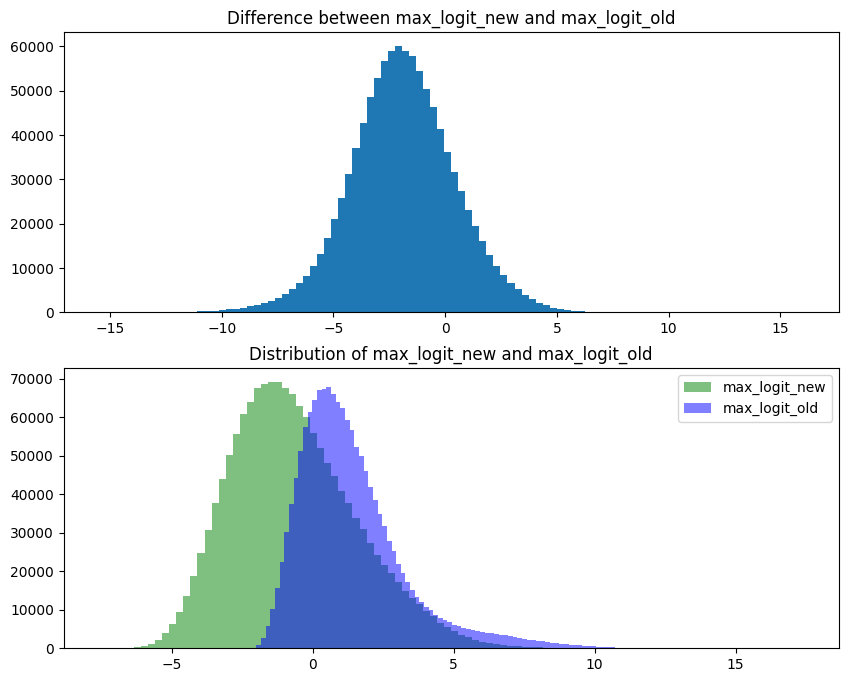

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].hist(no_unknowns_matching['max_logit_new'] - no_unknowns_matching['max_logit_old'], bins=100)
axs[0].set_title('Difference between max_logit_new and max_logit_old')

axs[1].hist(no_unknowns['max_logit_new'], bins=100, color='green', alpha=0.5, label='max_logit_new')
axs[1].hist(no_unknowns['max_logit_old'], bins=100, color='blue', alpha=0.5, label='max_logit_old')
axs[1].set_title('Distribution of max_logit_new and max_logit_old')
axs[1].legend()

plt.show()
plt.show()

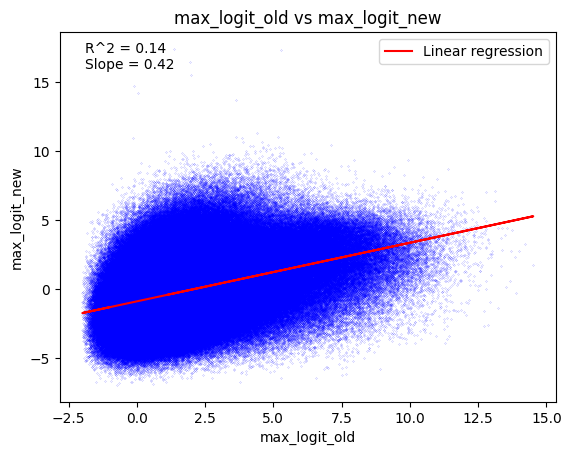

In [16]:
import numpy as np
from scipy.stats import linregress

# Calculate the best fit line with swapped axes
slope, intercept, r_value, p_value, std_err = linregress(
    no_unknowns_matching["max_logit_old"], no_unknowns_matching["max_logit_new"]
)
best_fit_line = slope * no_unknowns_matching["max_logit_old"] + intercept

# Plot the data points and the best fit line with swapped axes
plt.plot(
    no_unknowns_matching["max_logit_old"],
    no_unknowns_matching["max_logit_new"],
    "ob",
    markersize=0.1,
)
plt.plot(
    no_unknowns_matching["max_logit_old"],
    best_fit_line,
    "r-",
    label="Linear regression",
)

# Add the R^2 value to the plot
plt.text(
    0.05,
    0.9,
    f"R^2 = {r_value**2:.2f}\nSlope = {slope:.2f}",
    transform=plt.gca().transAxes,
)

plt.xlabel("max_logit_old")
plt.ylabel("max_logit_new")
plt.title("max_logit_old vs max_logit_new")
plt.legend()
plt.show()